In [14]:
import pandas as pd
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.exporter.xes import exporter as xes_exporter
from pm4py.objects.log.util import dataframe_utils
from datetime import datetime, timedelta
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.ilp import algorithm as ilp_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer


In [2]:

# Unique traces (one of each)
event_log = [
    "a,b,c,e",
    "a,c,b,e",
    "a,b,c,d,b,c,e",
    "a,c,b,d,b,c,e",
    "a,b,c,d,c,b,e"
]

# Create rows for CSV and XES
rows = []
for case_id, trace in enumerate(event_log, start=1):
    timestamp = datetime.now()
    activities = trace.split(",")
    for i, activity in enumerate(activities):
        rows.append({
            "case_id": f"Case_{case_id}",
            "activity": activity,
            "timestamp": timestamp + timedelta(seconds=i)
        })


In [4]:

# Create DataFrame
df = pd.DataFrame(rows)
df = df.sort_values(by=["case_id", "timestamp"])


In [8]:

# Save to CSV
df.to_csv("event_log.csv", index=False)

df = dataframe_utils.convert_timestamp_columns_in_df(df)

# Rename to PM4Py-compatible column names
df = df.rename(columns={
    "case_id": "case:concept:name",
    "activity": "concept:name",
    "timestamp": "time:timestamp"
})

# Set correct case ID key
parameters = {
    log_converter.Variants.TO_EVENT_LOG.value.Parameters.CASE_ID_KEY: "case:concept:name"
}

# Convert and export
log = log_converter.apply(df, parameters=parameters, variant=log_converter.Variants.TO_EVENT_LOG)
xes_exporter.apply(log, "event_log.xes")



exporting log, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/pm4py/util/dt_parsing/parser.py:82: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

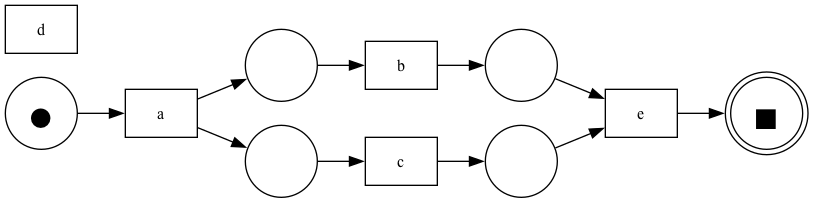

In [10]:
# 1. Load the XES log (created earlier)
log = xes_importer.apply("event_log.xes")

# 2. Apply the Alpha Miner algorithm
net, initial_marking, final_marking = alpha_miner.apply(log)

# 3. Visualize the resulting Petri net
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

discovering Petri net using ILP miner, completed causal relations ::   0%|          | 0/6 [00:00<?, ?it/s]

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/pm4py/objects/petri_net/utils/murata.py:138: UserWarning: solution from scipy may be unstable. Please install PuLP (pip install pulp) for fully reliable results.
  warnings.warn(


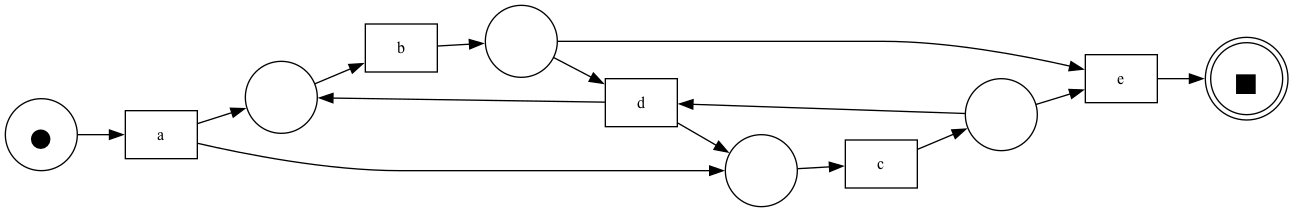

In [15]:
model_lip = ilp_miner.apply(log)
gviz = pn_visualizer.apply(model_lip[0], model_lip[1], model_lip[2])
pn_visualizer.view(gviz)